# Demo DCSM3D grid data

This small notebook shows how you can efficiently access remote gridded data serve somewhere on internet. The gridded data is available on a 4-dimensional grid, with dimensions time , layers , y and x. The size is 366x50x999x999. Selections of modest size can be downloaded efficiently directly from internet, as you will see below.

In [1]:
import ipywidgets as widgets
import datetime as dt
import pandas as pd
import numpy as np
import zarr
import fsspec
import requests
import aiohttp
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 8]


## Map files

The DCSM3D dataset has been converted to the efficient and internet friendly Zarr-format. For using the data through the Xarray library, there is very little difference compared to working with a similar NetCDF file locally, yet this allows one to make selections within enormous dataset that would not fit on the local computer.

Here the data is hosted on a http server through a commercial Nextcloud server. Other options are for example the object-store S3 by Amazon.

In [4]:
map_url="https://nx7384.your-storageshare.de/apps/sharingpath/wetwin/public/DCSM-FM-3D_map.zarr"
#map_url="../DCSM-FM-3D_map.zarr"
map=xr.open_zarr(map_url,consolidated=True)
map, map.dims

(<xarray.Dataset>
 Dimensions:      (time: 366, z: 50, y: 999, x: 999)
 Coordinates:
   * time         (time) datetime64[ns] 2012-01-01 ... 2014-12-31T12:00:00
 Dimensions without coordinates: z, y, x
 Data variables:
     salinity     (time, z, y, x) float32 ...
     temperature  (time, z, y, x) float32 ...
     waterlevel   (time, y, x) float32 ...
     x_center     (x) float64 ...
     x_velocity   (time, z, y, x) float32 ...
     y_center     (y) float64 ...
     y_velocity   (time, z, y, x) float32 ...
     z_center_3d  (time, z, y, x) float32 ...
 Attributes:
     date_created:   2021-09-01T15:53:30+0200
     history:        Created on 2021-09-01T15:53:30+0200, D-Flow FM
     date_modified:  2021-09-01T15:53:30+0200
     references:     http://www.deltares.nl
     source:         D-Flow FM 1.2.127.69374M. Model:
     institution:    Deltares
     Conventions:    CF-1.8 UGRID-1.0 Deltares-0.10,
 Frozen({'time': 366, 'z': 50, 'y': 999, 'x': 999}))

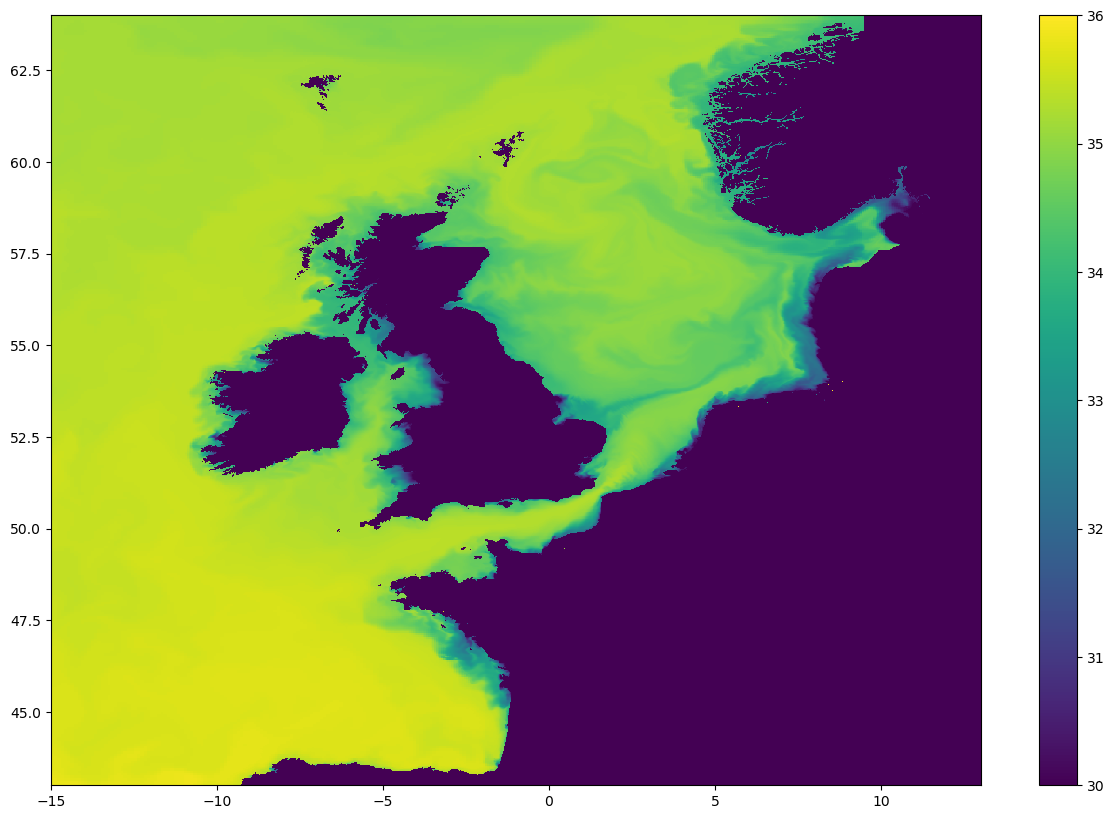

In [18]:
# Select one time and layer and plot for all x,y 
itime=29 # we start at 1-1-2014 12h and continue with 24h steps for the entire year
ilayer=49 # 0 at bottom and 49 at top
x=map.x_center # longitude [-15 ... 13]
y=map.y_center # latitude [43 ... 64]

# Variable is salinity here
sal_layer=map.salinity.isel(time=itime,z=ilayer)

# Plot salinity
fig,ax2 = plt.subplots(figsize=(15,10))
pc = ax2.pcolormesh(x,y,sal_layer,vmin=30,vmax=36)
fig.colorbar(pc,ax=ax2)

/tmp/ipykernel_34491/4239245563.py:18: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pc = ax2.pcolormesh(x,z.bfill(dim='z'),sal_prof,vmin=30,vmax=36)


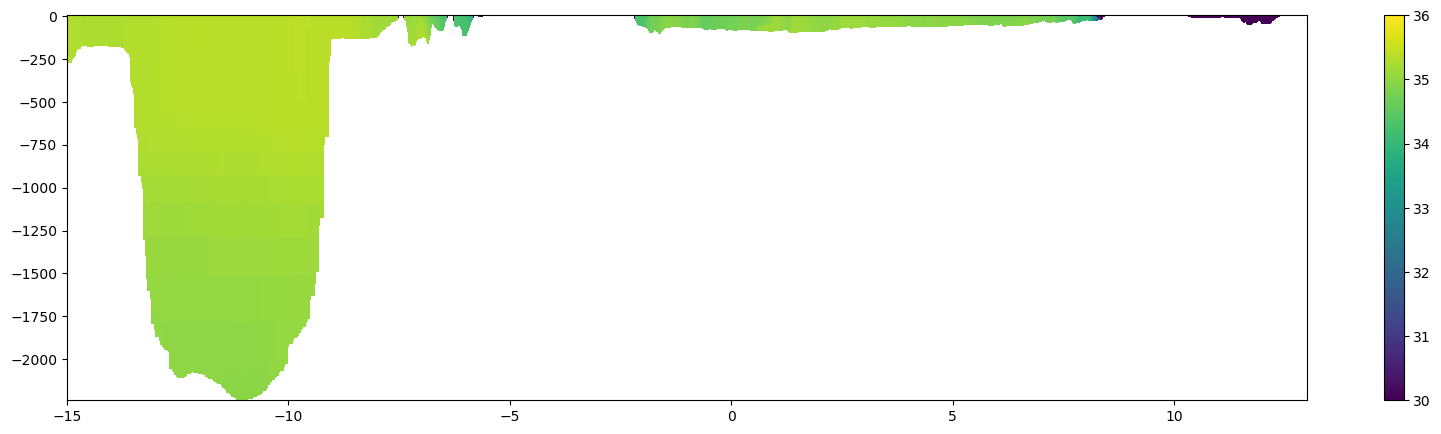

In [31]:
# Now plot salinity for a specific y cross section

def get_nearest_y(y_vector, y_value):
    idx = (np.abs(y_vector-y_value)).argmin()
    return idx

# Selection
itime = 9 # 9-JAN-2014 12h
y_value = 57.0 # latitude
iy = get_nearest_y(map.y_center.values,y_value)

map_nc_sel = map.isel(time=itime,y=iy)
z = map_nc_sel.z_center_3d
sal_prof = map_nc_sel.salinity

# Plot salinity cross section
fig,ax2 = plt.subplots(figsize=(20,5))
pc = ax2.pcolormesh(x,z.bfill(dim='z'),sal_prof,vmin=30,vmax=36)
fig.colorbar(pc,ax=ax2)